In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import matplotlib.dates as mdates
from datetime import datetime, timezone

In [2]:
data = xr.open_dataset('../data/model/summit.nc')

In [3]:
dn0 = data.DN0.load()
raincond = ((data.VAPRAINT + data.VAPDRIZT) * dn0 * 1e3 / 5.0).integrate('z').load()
cldcond = ((data.NUCCLDRT + data.VAPCLDT) * dn0 * 1e3 / 5.0).integrate('z').load()
icecond = ((data.VAPICET + data.NUCICERT) * dn0 * 1e3 / 5.0).integrate('z').load()
melt = (data.MELTICET * dn0 * 1e3 / 5.0).integrate('z').load()
freeze = ((data.INUCHOMRT + data.INUCCONTRT + data.INUCIFNRT) * dn0 * 1e3/5.0).integrate('z').load()
rime = ((data.RIMECLDT + data.RAIN2ICET) * dn0 * 1e3 / 5.0).integrate('z').load()
liqsed = (data.ACCPR + data.ACCPD).diff('time').load() * 1e3 / 5.0
icesed = (data.ACCPP + data.ACCPS + data.ACCPA + data.ACCPG + data.ACCPH).diff('time').load() * 1e3 / 5.0
radheat =  data.FTHRD[2:,:].load() * 3600
turb = (data.WC[2:,:]**2).load()

In [4]:
t1 = data.time[0].values + np.timedelta64(3, 'h')
t2 = t1 + np.timedelta64(9,'h')

In [5]:
liqgrow = (data.NUCCLDRT + data.VAPLIQT)[2:].load() / 5 * dn0[2:] * 1e3
icegrow = (data.NUCICERT + data.VAPICET)[2:].load() / 5 * dn0[2:] * 1e3

In [6]:
import pandas as pd

In [7]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
# plt.rc('colorbar', fontsize=12)
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [8]:
t = datetime(2019, 7, 2, 6, 0, tzinfo=timezone.utc)

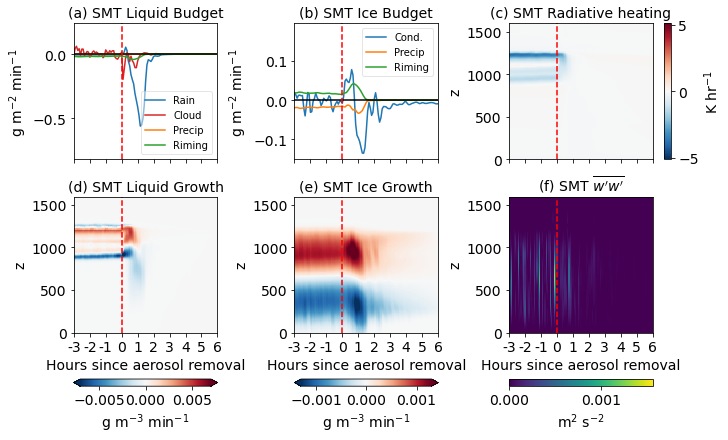

In [9]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(10,6), sharex='col', 
                                                        constrained_layout=True)
# Liquid Budget
raincond[2:].plot(label='Rain', color='C0', ax=ax1)
cldcond[2:].plot(label='Cloud', color='C3', ax=ax1)

(-1*liqsed[2:]).plot(label='Precip', color='C1', ax=ax1)
(-1*rime[2:]).plot(label='Riming', color='C2', ax=ax1)

ax1.axhline(0, color='k')
# ax1.axvline(data.time[0].values + np.timedelta64(6,'h'), color='red', linestyle='dashed')
ax1.set_title("(a) SMT Liquid Budget")
ax1.set_ylabel("g m$^{-2}$ min$^{-1}$")
ax1.set_xlabel("")
ax1.legend(loc='lower right', framealpha=0.5)

ax1.set_xlim(t1, t2)

# Ice Budget
icecond[2:].plot(label='Cond.', ax=ax2)
(-1*icesed[2:]).plot(label='Precip', ax=ax2)
(rime[2:]).plot(label='Riming', ax=ax2)
ax2.legend(loc='upper right', framealpha=0.5)


ax2.axhline(0, color='k')
# ax2.axvline(data.time[0].values + np.timedelta64(6,'h'), color='red', linestyle='dashed')
ax2.set_title("(b) SMT Ice Budget")
ax2.set_ylabel("g m$^{-2}$ min$^{-1}$")
ax2.set_xlabel("")

ax2.set_xlim(t1, t2)

# Radiative cooling
radheat.plot.pcolormesh('time', 'z', ax=ax3, cbar_kwargs=dict(label='K hr$^{-1}$', orientation='vertical'))
ax3.set_xlabel("")
ax3.set_title("(c) SMT Radiative heating")

ax3.set_xlim(t1, t2)

# Liquid 2D
liqgrow.plot.pcolormesh('time', 'z', ax=ax4, 
                        cbar_kwargs=dict(label='g m$^{-3}$ min$^{-1}$', orientation='horizontal'),
                        vmin=-.007, vmax=0.007, cmap='RdBu_r'
)
ax4.set_xlabel("")
ax4.set_title("(d) SMT Liquid Growth")

ax4.set_xlim(t1, t2)

# Ice 2D
p5 = icegrow.plot.pcolormesh('time', 'z', ax=ax5, add_colorbar=True, 
                            vmin=-1.3e-3, vmax=1.3e-3, cmap='RdBu_r',
                            cbar_kwargs = dict(label='g m$^{-3}$ min$^{-1}$', orientation='horizontal',)
)
# cbar5 = plt.colorbar(p5, ax=ax5, label='g m$^{-3}$ min$^{-1}$', 
#                      orientation='horizontal'
# )
# cbar5.formatter.set_powerlimits((0,0))
ax5.set_xlabel("")
ax5.set_title("(e) SMT Ice Growth")

ax5.set_xlim(t1, t2)

# Turbulence
turb.plot.pcolormesh('time', 'z', ax=ax6, cbar_kwargs=dict(label='m$^2$ s$^{-2}$', orientation='horizontal'))
ax6.set_xlabel("")
ax6.set_title("(f) SMT $\overline{w^\prime w^\prime}$")

ax6.set_xlim(t1, t2)

majorticks = ax6.get_xticks()
# majorticklabels = [a.strftime('%Hz') for a in mdates.num2date(majorticks)]

for ax in (ax4, ax5, ax6):
    ax.set_xticks(majorticks)
    ticks = (np.asarray(mdates.num2date(ax.get_xticks())) - t).astype('timedelta64[h]').astype(int)
    ax.set_xticklabels(ticks, rotation=0, ha='center')
    ax.set_xlabel('Hours since aerosol removal')

for ax in (ax1, ax2, ax3, ax4, ax5, ax6):
    ax.axvline(data.time[0].values + np.timedelta64(6, 'h'), color='red', linestyle='dashed')

# plt.savefig('greenland_budget.png', facecolor='w')